<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/inpainting/latent_diffusion_inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Ref Docs
# https://github.com/CompVis/latent-diffusion

In [ ]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

In [ ]:
#@title Download
%cd latent-diffusion/ 

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

In [3]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip install kornia

In [ ]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


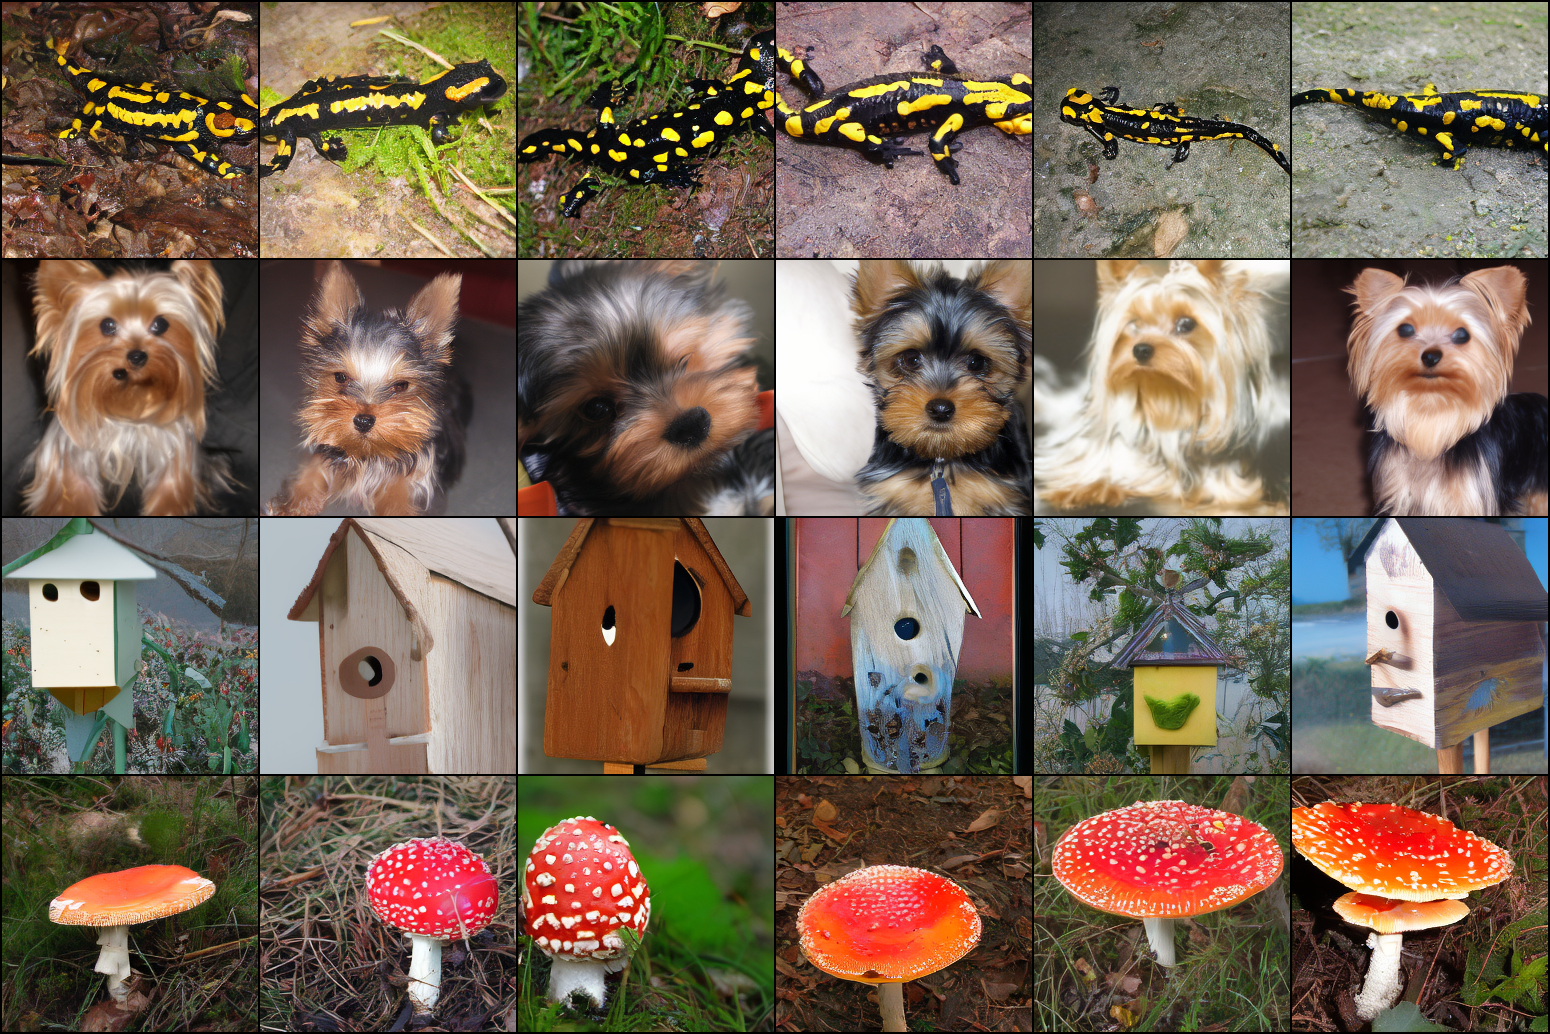

In [9]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [ ]:
#@title inpaint
!wget -O models/ldm/inpainting_big/last.ckpt https://heibox.uni-heidelberg.de/f/4d9ac7ea40c64582b7c9/?dl=1

In [ ]:
%cd /content/latent-diffusion

In [ ]:
import argparse, os, sys, glob
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler


def make_batch(image, mask, device):
    image = np.array(Image.open(image).convert("RGB"))
    image = image.astype(np.float32)/255.0
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    mask = np.array(Image.open(mask).convert("L"))
    mask = mask.astype(np.float32)/255.0
    mask = mask[None,None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = (1-mask)*image

    batch = {"image": image, "mask": mask, "masked_image": masked_image}
    for k in batch:
        batch[k] = batch[k].to(device=device)
        batch[k] = batch[k]*2.0-1.0
    return batch

indir = "data/myexamples/"
outdir = "outputs/inpainting_results"
steps = 50

masks = sorted(glob.glob(os.path.join(indir, "*_mask.png")))
images = [x.replace("_mask.png", ".png") for x in masks]
print(f"Found {len(masks)} inputs.")

config = OmegaConf.load("models/ldm/inpainting_big/config.yaml")
model = instantiate_from_config(config.model)
model.load_state_dict(torch.load("models/ldm/inpainting_big/last.ckpt")["state_dict"],
                          strict=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = DDIMSampler(model)

os.makedirs(outdir, exist_ok=True)
with torch.no_grad():
  with model.ema_scope():
    for image, mask in tqdm(zip(images, masks)):
      outpath = os.path.join(outdir, os.path.split(image)[1])
      batch = make_batch(image, mask, device=device)

      # encode masked image and concat downsampled mask
      c = model.cond_stage_model.encode(batch["masked_image"])
      cc = torch.nn.functional.interpolate(batch["mask"],
                                                     size=c.shape[-2:])
      c = torch.cat((c, cc), dim=1)

      shape = (c.shape[1]-1,)+c.shape[2:]
      samples_ddim, _ = sampler.sample(S=steps,
                                                 conditioning=c,
                                                 batch_size=c.shape[0],
                                                 shape=shape,
                                                 verbose=False)
      x_samples_ddim = model.decode_first_stage(samples_ddim)

      image = torch.clamp((batch["image"]+1.0)/2.0,
                                    min=0.0, max=1.0)
      mask = torch.clamp((batch["mask"]+1.0)/2.0,
                                   min=0.0, max=1.0)
      predicted_image = torch.clamp((x_samples_ddim+1.0)/2.0,
                                              min=0.0, max=1.0)

      inpainted = (1-mask)*image+mask*predicted_image
      inpainted = inpainted.cpu().numpy().transpose(0,2,3,1)[0]*255
      Image.fromarray(inpainted.astype(np.uint8)).save(outpath)